# Error analysis notebook (test data)

## Import packages

In [16]:
import pandas as pd
import math

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from elasticsearch import Elasticsearch

import warnings
import matplotlib
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
warnings.filterwarnings("ignore")

from enum import IntEnum

import json


## Set filepaths

In [17]:
ranking_meta_9 = '../evaluation/resources/2020/jsonruns/p_controller_train_nle_meta_9_1_train_level.json'
ranking_meta_99 = '../evaluation/resources/2020/jsonruns/p_controller_train_nle_meta_99_1_train_level.json'
ranking_text_9 = '../evaluation/resources/2020/jsonruns/p_controller_train_nle_text_9_1_train_level.json'
ranking_text_99 = '../evaluation/resources/2020/jsonruns/p_controller_train_nle_text_99_1_train_level.json'

eval_result_hlevel_meta_9 = '../evaluation/resources/2020/eval_results/p_controller_train_nle_meta_9_1_train_hlevel.tsv'
eval_result_level_meta_9 = '../evaluation/resources/2020/eval_results/p_controller_train_nle_meta_9_1_train_level.tsv'

eval_result_hlevel_meta_99 = '../evaluation/resources/2020/eval_results/p_controller_train_nle_meta_99_1_train_hlevel.tsv'
eval_result_level_meta_99 = '../evaluation/resources/2020/eval_results/p_controller_train_nle_meta_99_1_train_level.tsv'

eval_result_hlevel_text_9 = '../evaluation/resources/2020/eval_results/p_controller_train_nle_text_9_1_train_hlevel.tsv'
eval_result_level_text_9 = '../evaluation/resources/2020/eval_results/p_controller_train_nle_text_9_1_train_level.tsv'

eval_result_hlevel_text_99 = '../evaluation/resources/2020/eval_results/p_controller_train_nle_text_99_1_train_hlevel.tsv'
eval_result_level_text_99 = '../evaluation/resources/2020/eval_results/p_controller_train_nle_text_99_1_train_level.tsv'

eval_result_meta_9_noauth_docid = '../evaluation/resources/2020/eval_results/p_controller_train_nle_meta_9_1_train_noauth_docid.tsv'
eval_result_meta_9_noauth_anon =  '../evaluation/resources/2020/eval_results/p_controller_train_nle_meta_9_1_train_noauth_anon.tsv'
eval_result_meta_9_doc_singleton =  '../evaluation/resources/2020/eval_results/p_controller_train_nle_meta_9_1_train_doc_singleton.tsv'

gt = '../pre_processing/resources/training/2020/TREC-Fair-Ranking-training-sample.json'

est_rel_meta_f = '../reranking/resources/relevances/Training_rel_scores_model_A.csv'
est_rel_text_f = '../reranking/resources/relevances/Training_rel_scores_model_B.csv'

annotations = '../pre_pre_processing/resources/merged-annotations.json'
mapping = '../reranking/resources/mappings/training_doc_to_author.json'

## Prepare dataframes

In [19]:
# ranking df
rdf_meta_9 = pd.read_json(ranking_meta_9, lines=True)
rdf_meta_99 = pd.read_json(ranking_meta_9, lines=True)
rdf_text_9 = pd.read_json(ranking_text_9, lines=True)
rdf_text_99 = pd.read_json(ranking_text_99, lines=True)

# ground truth df
gtdf = pd.read_json(gt, lines=True).explode('documents')
gtdf['doc_id'] = gtdf.documents.apply(lambda row: row.get('doc_id'))
gtdf['doc_rel'] = gtdf.documents.apply(lambda row: row.get('relevance'))

# paired down relevances df
reldf = gtdf[['qid','query','doc_id','doc_rel']]

# eval result dfs
ehldf_meta_9 = pd.read_csv(eval_result_hlevel_meta_9, sep='\t', names=['key', 'qid', 'value'])
ehldf_meta_9 = ehldf_meta_9.pivot(index='qid', columns='key', values='value')
eldf_meta_9 = pd.read_csv(eval_result_level_meta_9, sep='\t', names=['key', 'qid', 'value'])
eldf_meta_9 = eldf_meta_9.pivot(index='qid', columns='key', values='value')

ehldf_meta_99 = pd.read_csv(eval_result_hlevel_meta_99, sep='\t', names=['key', 'qid', 'value'])
ehldf_meta_99 = ehldf_meta_99.pivot(index='qid', columns='key', values='value')
eldf_meta_99 = pd.read_csv(eval_result_level_meta_99, sep='\t', names=['key', 'qid', 'value'])
eldf_meta_99 = eldf_meta_99.pivot(index='qid', columns='key', values='value')

ehldf_text_9 = pd.read_csv(eval_result_hlevel_text_9, sep='\t', names=['key', 'qid', 'value'])
ehldf_text_9 = ehldf_text_9.pivot(index='qid', columns='key', values='value')
eldf_text_9 = pd.read_csv(eval_result_level_text_9, sep='\t', names=['key', 'qid', 'value'])
eldf_text_9 = eldf_text_9.pivot(index='qid', columns='key', values='value')

ehldf_text_99 = pd.read_csv(eval_result_hlevel_text_99, sep='\t', names=['key', 'qid', 'value'])
ehldf_text_99 = ehldf_text_99.pivot(index='qid', columns='key', values='value')
eldf_text_99 = pd.read_csv(eval_result_level_text_99, sep='\t', names=['key', 'qid', 'value'])
eldf_text_99 = eldf_text_99.pivot(index='qid', columns='key', values='value')

meta_9_noauth_anon_df = pd.read_csv(eval_result_meta_9_noauth_anon, sep='\t', names=['key', 'qid', 'value'])
meta_9_noauth_anon_df = meta_9_noauth_anon_df.pivot(index='qid', columns='key', values='value')

meta_9_noauth_docid_df = pd.read_csv(eval_result_meta_9_noauth_docid, sep='\t', names=['key', 'qid', 'value'])
meta_9_noauth_docid_df = meta_9_noauth_docid_df.pivot(index='qid', columns='key', values='value')

meta_9_doc_singleton_df = pd.read_csv(eval_result_meta_9_doc_singleton, sep='\t', names=['key', 'qid', 'value'])
meta_9_doc_singleton_df = meta_9_doc_singleton_df.pivot(index='qid', columns='key', values='value')





# est rel df
est_rel_meta = pd.read_csv(est_rel_meta_f)
est_rel_text = pd.read_csv(est_rel_text_f)


# annotations
adf = pd.read_json(annotations,lines=True)
adf = adf.explode('authors')
adf[['name','wiki','country','type','valid','auth_id', 'h_index','level','region']] = adf.authors.apply(pd.Series).rename({'id':'auth_id'},axis=1)

# doc to author and reverse mapping
with open(mapping) as fp:
    doc_to_author = json.load(fp)
    
alldocs = rdf_meta_9.explode('ranking')['ranking'].drop_duplicates().to_list()
for doc in alldocs:
    if not doc in doc_to_author:
        doc_to_author[doc] = []
    
author_to_doc = {}
for doc, aulist in doc_to_author.items():
    for au in aulist:
        if not au in author_to_doc:
            author_to_doc[au] = []
        author_to_doc[au] = author_to_doc[au] + [doc]

In [20]:
ehldf_meta_9[['difference','disparity','relevance']].mean()

key
difference    0.434440
disparity     1.753156
relevance     1.252646
dtype: float64

In [21]:
eldf_meta_9[['difference','disparity','relevance']].mean()

key
difference    0.426751
disparity     1.951181
relevance     1.388441
dtype: float64

In [22]:
ehldf_meta_99[['difference','disparity','relevance']].mean()

key
difference    0.430280
disparity     1.750343
relevance     1.253320
dtype: float64

In [23]:
eldf_meta_99[['difference','disparity','relevance']].mean()

key
difference    0.424715
disparity     1.948928
relevance     1.388333
dtype: float64

In [24]:
ehldf_text_9[['difference','disparity','relevance']].mean()

key
difference    0.446377
disparity     1.765455
relevance     1.252827
dtype: float64

In [25]:
eldf_text_9[['difference','disparity','relevance']].mean()

key
difference    0.441600
disparity     1.968173
relevance     1.389513
dtype: float64

In [26]:
ehldf_text_99[['difference','disparity','relevance']].mean()

key
difference    0.457462
disparity     1.779201
relevance     1.254157
dtype: float64

In [27]:
eldf_text_99[['difference','disparity','relevance']].mean()

key
difference    0.455718
disparity     1.983619
relevance     1.390177
dtype: float64

In [28]:
meta_9_noauth_anon_df[['difference','disparity','relevance']].mean()

key
difference    1.545262
disparity     0.809855
relevance     0.536687
dtype: float64

In [29]:
meta_9_noauth_docid_df[['difference','disparity','relevance']].mean()

key
difference    1.550297
disparity     0.806018
relevance     0.532002
dtype: float64

In [30]:
meta_9_doc_singleton_df[['difference','disparity','relevance']].mean()

key
difference    0.562098
disparity     0.263787
relevance     0.145674
dtype: float64

In [44]:
set(eldf_meta_9.sort_values(by='difference').tail(10).reset_index().qid.to_list()).intersection(meta_9_noauth_anon_df.sort_values(by='difference').tail(10).reset_index().qid.to_list())

{33337}

In [39]:
meta_9_noauth_anon_df.sort_values(by='difference').tail(10)

key,difference,disparity,relevance
qid,,,
29979,4.050845,1.260625,0.955970
40748,4.214315,2.922428,2.720304
64039,4.352173,4.078946,3.577946
33337,4.585438,3.738013,0.570916
29208,4.669166,2.422751,2.418655
23241,5.545022,1.969447,2.921267
16040,5.801210,1.114392,0.392754
12828,7.497633,1.570728,2.509430
46090,8.229418,12.413544,5.083313


In [31]:
def plot_relevance_disparity(df, title):
    df = df.sort_values(by='difference').reset_index(drop=True).reset_index().rename({'index':'difficulty'}, axis=1)
    disp = df[["difficulty","disparity"]].rename({'disparity':'value'}, axis=1)
    relv = df[["difficulty","relevance"]].rename({'relevance':'value'}, axis=1)
    conc = pd.concat([disp.assign(metric='disparity'), relv.assign(metric='relevance')])

    fig, ax = plt.subplots(1,1,figsize = (17.7,8.27))

    pi = iter(sns.color_palette())
    f = next(pi)
    s = next(pi)

    sns.scatterplot(data=conc, x='difficulty', y='value',hue='metric',ax=ax)

    fig.suptitle(f'Relevance and disparity versus difficulty for {title}')

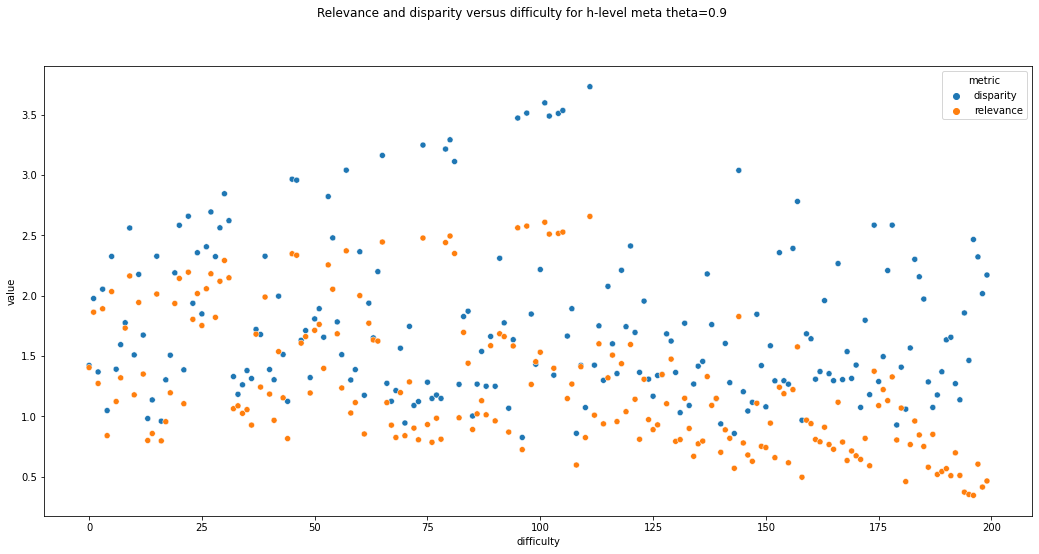

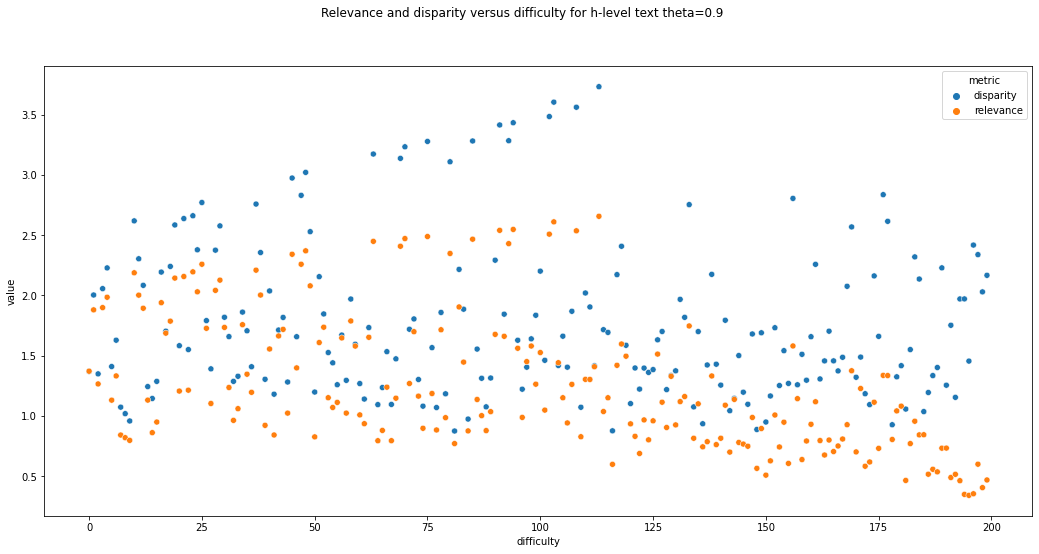

In [79]:
plot_relevance_disparity(ehldf_meta_9, "h-level meta theta=0.9")
plot_relevance_disparity(ehldf_text_9, "h-level text theta=0.9")

In [83]:
ehldf_meta_9.sort_values(by='difference').reset_index(drop=True).reset_index().rename({'index':'difficulty'}, axis=1).head()

key,difficulty,difference,disparity,relevance
0,0,0.002713,1.421254,1.403715
1,1,0.029287,1.975807,1.862498
2,2,0.032334,1.367385,1.271935
3,3,0.040510,2.053024,1.890567
4,4,0.057478,1.047360,0.839632


In [89]:
ehldf_text_9.reset_index(drop=True).reset_index().rename({'index':'difficulty'}, axis=1).head()

key,difficulty,difference,disparity,relevance
0,0,0.147297,2.830163,2.258533
1,1,0.507917,1.042814,0.699428
2,2,0.588716,1.689528,0.895089
3,3,0.175217,1.095032,0.793987
4,4,1.375564,2.228446,0.732000


In [97]:
ehldf_meta_9.sort_values(by='difference').reset_index().reset_index().head()

key,index,qid,difference,disparity,relevance
0,0,132049,0.002713,1.421254,1.403715
1,1,71096,0.029287,1.975807,1.862498
2,2,21984,0.032334,1.367385,1.271935
3,3,15395,0.040510,2.053024,1.890567
4,4,52728,0.057478,1.047360,0.839632


In [100]:
ehldf_text_9.sort_values(by='difference').reset_index().reset_index().head()

key,index,qid,difference,disparity,relevance
0,0,132049,0.016562,1.369404,1.370865
1,1,71096,0.022032,2.003198,1.879820
2,2,21984,0.027258,1.348613,1.265088
3,3,15395,0.027580,2.055981,1.898511
4,4,35778,0.063951,2.228007,1.984610


In [102]:
ehldf_9 = pd.merge(ehldf_meta_9.sort_values(by='difference').reset_index().reset_index(),ehldf_text_9.sort_values(by='difference').reset_index().reset_index(),on='qid')
ehldf_9.head()

key,index_x,qid,difference_x,disparity_x,relevance_x,index_y,difference_y,disparity_y,relevance_y
0,0,132049,0.002713,1.421254,1.403715,0,0.016562,1.369404,1.370865
1,1,71096,0.029287,1.975807,1.862498,1,0.022032,2.003198,1.879820
2,2,21984,0.032334,1.367385,1.271935,2,0.027258,1.348613,1.265088
3,3,15395,0.040510,2.053024,1.890567,3,0.027580,2.055981,1.898511
4,4,52728,0.057478,1.047360,0.839632,7,0.079677,1.072401,0.841053


In [127]:
ehldf_9.mean()

key
index_x            99.500000
qid             47446.320000
difference_x        0.434440
disparity_x         1.753156
relevance_x         1.252646
index_y            99.500000
difference_y        0.446377
disparity_y         1.765455
relevance_y         1.252827
dtype: float64

In [128]:
ehldf_99 = pd.merge(ehldf_meta_99.sort_values(by='difference').reset_index().reset_index(),ehldf_text_99.sort_values(by='difference').reset_index().reset_index(),on='qid')
ehldf_99.mean()

key
index_x            99.500000
qid             47446.320000
difference_x        0.430280
disparity_x         1.750343
relevance_x         1.253320
index_y            99.500000
difference_y        0.457462
disparity_y         1.779201
relevance_y         1.254157
dtype: float64

In [129]:
eldf_9 = pd.merge(eldf_meta_9.sort_values(by='difference').reset_index().reset_index(),eldf_text_9.sort_values(by='difference').reset_index().reset_index(),on='qid')
eldf_9.mean()

key
index_x            99.500000
qid             47446.320000
difference_x        0.426751
disparity_x         1.951181
relevance_x         1.388441
index_y            99.500000
difference_y        0.441600
disparity_y         1.968173
relevance_y         1.389513
dtype: float64

In [130]:
eldf_99 = pd.merge(eldf_meta_99.sort_values(by='difference').reset_index().reset_index(),eldf_text_99.sort_values(by='difference').reset_index().reset_index(),on='qid')
eldf_99.mean()

key
index_x            99.500000
qid             47446.320000
difference_x        0.424715
disparity_x         1.948928
relevance_x         1.388333
index_y            99.500000
difference_y        0.455718
disparity_y         1.983619
relevance_y         1.390177
dtype: float64

In [121]:
def plot_rel_or_disp_of_one_vs_the_other(merged,metric,title):
    
    metr_x = merged[[f'{metric}_x']].rename({f'{metric}_x':'value'},axis=1)
    metr_y = merged[[f'{metric}_y']].rename({f'{metric}_y':'value'}, axis=1)
    
    
    conc = pd.concat([metr_x.assign(source='x'), metr_y.assign(source='y')])

    fig, ax = plt.subplots(1,1,figsize = (17.7,8.27))

    pi = iter(sns.color_palette())
    f = next(pi)
    s = next(pi)

    print(conc.reset_index())
    
    sns.scatterplot(data=conc.reset_index(), x='index', y='value',hue='source',ax=ax)

    fig.suptitle(f'Relevance and disparity versus difficulty for {title}')
    
    
    

key  index     value source
0        0  1.421254      x
1        1  1.975807      x
2        2  1.367385      x
3        3  2.053024      x
4        4  1.047360      x
..     ...       ...    ...
395    195  1.454738      y
396    196  2.417624      y
397    197  2.338418      y
398    198  2.029064      y
399    199  2.166522      y

[400 rows x 3 columns]


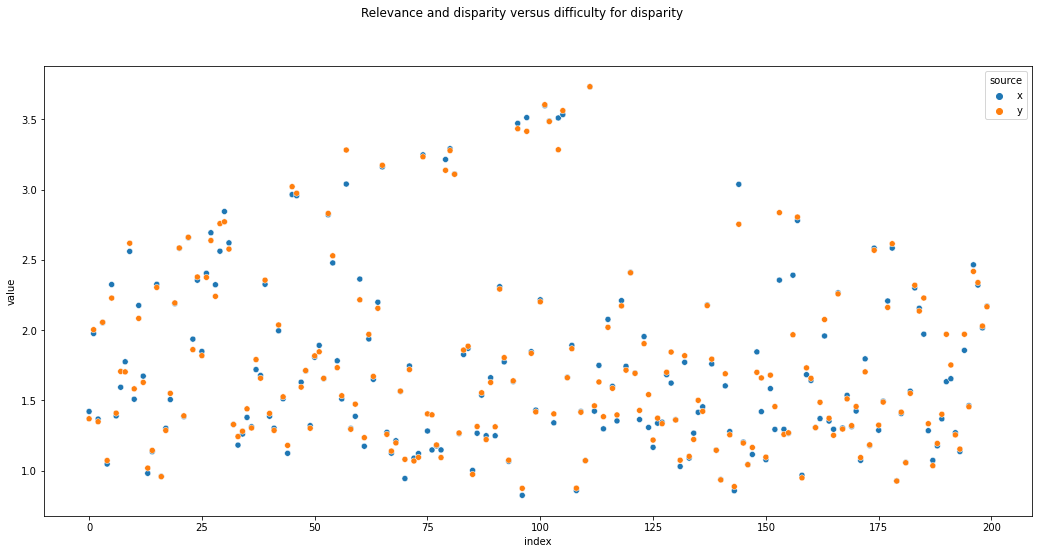

In [123]:
plot_rel_or_disp_of_one_vs_the_other(ehldf_9,'disparity','disparity')

key  index     value source
0        0  1.403715      x
1        1  1.862498      x
2        2  1.271935      x
3        3  1.890567      x
4        4  0.839632      x
..     ...       ...    ...
395    195  0.340295      y
396    196  0.353428      y
397    197  0.599045      y
398    198  0.404400      y
399    199  0.468046      y

[400 rows x 3 columns]


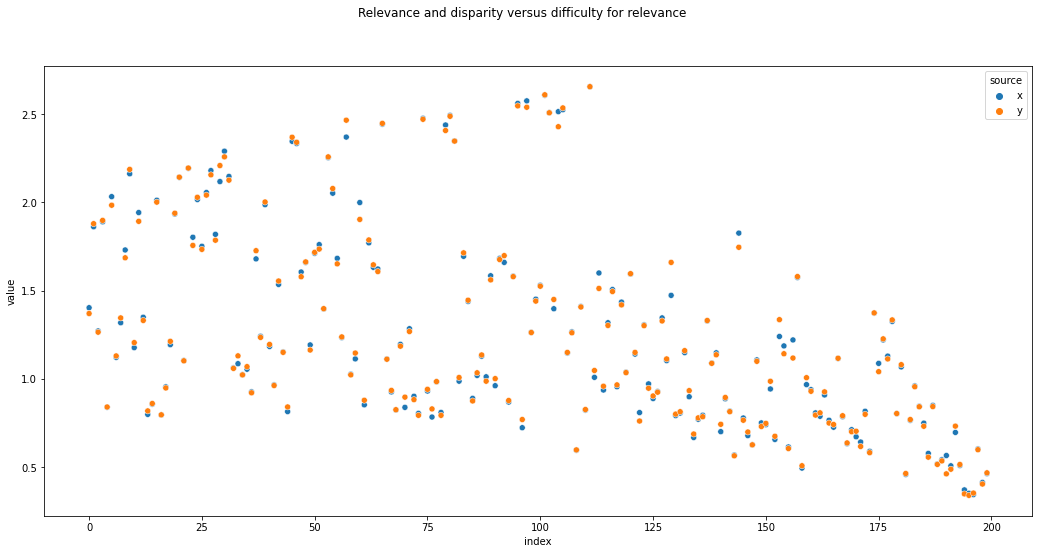

In [125]:
plot_rel_or_disp_of_one_vs_the_other(ehldf_9,'relevance','relevance')

In [124]:
dif_disp_rel = edf.reset_index(drop=True).reset_index().rename({'index':'difficulty'}, axis=1)
disp = dif_disp_rel[["difficulty","disparity"]].rename({'disparity':'value'}, axis=1)
relp = dif_disp_rel[["difficulty","relevance"]].rename({'relevance':'value'}, axis=1)
concatenated = pd.concat([disp.assign(metric='disparity'), relp.assign(metric='relevance')])
concatenated.head()

NameError: name 'edf' is not defined

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (17.7,8.27))

pi = iter(sns.color_palette())
f = next(pi)
s = next(pi)

sns.scatterplot(data=concatenated, x='difficulty', y='value',hue='metric',ax=ax)



fig.suptitle('Relevance and disparity versus difficulty')

In [ ]:
edf_m = pd.merge(ehldf.sort_values(by='difference').reset_index().reset_index(),eldf.sort_values(by='difference').reset_index().reset_index(),on='qid')

In [15]:
edf_m = pd.merge(ehldf.sort_values(by='difference').reset_index().reset_index(),eldf.sort_values(by='difference').reset_index().reset_index(),on='qid')
edf_m = edf_m.rename({'index_x':'difficulty hlevel', 'index_y':'difficulty econ level'},axis=1)
edf_m.head()

key,difficulty hlevel,qid,difference_x,disparity_x,relevance_x,difficulty econ level,difference_y,disparity_y,relevance_y
0,0,132049,0.002713,1.421254,1.403715,0,0.002713,1.421254,1.403715
1,1,71096,0.029287,1.975807,1.862498,1,0.026328,1.972820,1.862484
2,2,21984,0.032334,1.367385,1.271935,6,0.071535,1.515766,1.326630
3,3,15395,0.040510,2.053024,1.890567,2,0.026948,2.035232,1.888323
4,4,52728,0.057478,1.047360,0.839632,13,0.098930,1.011948,0.728643


We see a clear upward trend in the plot above. This tells us that in general, the DGEE according to the two groupings is similar. We would not expect great differences in the analysis results for different groupings.

In [16]:
edf = edf_m.copy()
edf['difference'] = edf.apply(lambda row: (row.difference_x + row.difference_y)/2, axis=1)
edf['disparity'] = edf.apply(lambda row: (row.disparity_x + row.disparity_y)/2, axis=1)
edf['relevance'] = edf.apply(lambda row: (row.relevance_x + row.relevance_y)/2, axis=1)

edf = edf.sort_values(by='difference')[['qid','difference', 'disparity', 'relevance']]
edf.head()

key,qid,difference,disparity,relevance
0,132049,0.002713,1.421254,1.403715
1,71096,0.027807,1.974314,1.862491
3,15395,0.033729,2.044128,1.889445
2,21984,0.051934,1.441575,1.299282
4,52728,0.078204,1.029654,0.784137


In [17]:
edf.head()

key,qid,difference,disparity,relevance
0,132049,0.002713,1.421254,1.403715
1,71096,0.027807,1.974314,1.862491
3,15395,0.033729,2.044128,1.889445
2,21984,0.051934,1.441575,1.299282
4,52728,0.078204,1.029654,0.784137


## A or B leads to better relative ordering?

- Does better estimated relevance lead to more fairness or to more relevance?  
  - Check with B-set, it performs a little worse, are the est rel also further away?  
  - Or is the relative ordering worse?  

In [41]:
from collections import Counter

In [68]:
def count_number_of_zeros_before_ones(qid,est_rel1,est_rel2):
    
    est_rel1 = est_rel1[est_rel1.qid == qid]
    est_rel1 = est_rel1.sort_values(by='est_relevance',ascending=False)
    rels1 = est_rel1.relevance.to_list()
    lastone1 = len(rels1) - 1 - rels1[::-1].index(1)
    subrels1 = rels1[0:lastone1]
    
    est_rel2 = est_rel2[est_rel2.qid == qid]
    est_rel2 = est_rel2.sort_values(by='est_relevance',ascending=False)
    rels2 = est_rel2.relevance.to_list()
    lastone2 = len(rels2) - 1 - rels2[::-1].index(1)
    subrels2 = rels2[0:lastone2]
    
    print(qid, "\t,",Counter(subrels1)[0],"\t,",Counter(subrels2)[0], "\t",Counter(subrels1)[0]-Counter(subrels2)[0])
    return Counter(subrels1)[0], Counter(subrels2)[0]

In [69]:
aa, bb = 0, 0
for qid in est_rel_meta.qid.drop_duplicates().to_list():
    A, B = count_number_of_zeros_before_ones(qid, est_rel_meta,est_rel_text)
    aa += A
    bb += B
print(aa/200)
print(bb/200)

5438 	, 15 	, 16 	 -1
23837 	, 19 	, 9 	 10
89123 	, 3 	, 3 	 0
109411 	, 6 	, 5 	 1
59671 	, 19 	, 18 	 1
24365 	, 14 	, 22 	 -8
73836 	, 6 	, 10 	 -4
18717 	, 1 	, 1 	 0
9536 	, 2 	, 7 	 -5
439 	, 47 	, 71 	 -24
129480 	, 2 	, 2 	 0
38810 	, 8 	, 0 	 8
33818 	, 9 	, 9 	 0
62246 	, 0 	, 0 	 0
111080 	, 7 	, 3 	 4
67184 	, 2 	, 1 	 1
568 	, 15 	, 21 	 -6
71096 	, 11 	, 15 	 -4
13832 	, 16 	, 15 	 1
20710 	, 6 	, 6 	 0
75701 	, 5 	, 4 	 1
40748 	, 2 	, 2 	 0
61794 	, 6 	, 6 	 0
49868 	, 7 	, 6 	 1
94840 	, 7 	, 7 	 0
66896 	, 15 	, 16 	 -1
99619 	, 18 	, 7 	 11
42519 	, 8 	, 9 	 -1
9455 	, 11 	, 12 	 -1
56263 	, 0 	, 0 	 0
65309 	, 5 	, 5 	 0
28270 	, 16 	, 17 	 -1
32559 	, 1 	, 2 	 -1
107238 	, 7 	, 8 	 -1
59256 	, 22 	, 26 	 -4
95424 	, 14 	, 12 	 2
21984 	, 15 	, 14 	 1
3661 	, 9 	, 6 	 3
16040 	, 23 	, 23 	 0
70381 	, 25 	, 25 	 0
47984 	, 13 	, 7 	 6
54538 	, 11 	, 9 	 2
59905 	, 1 	, 4 	 -3
84087 	, 5 	, 9 	 -4
90609 	, 9 	, 12 	 -3
13464 	, 7 	, 13 	 -6
53737 	, 7 	, 9 	 -2
82442

In [67]:
for qid in est_rel_meta.qid.drop_duplicates().to_list():
    count_number_of_zeros_before_ones(qid, est_rel_meta,est_rel_text)

5438 	, 15 	, 16 	 -1
23837 	, 19 	, 9 	 10
89123 	, 3 	, 3 	 0
109411 	, 6 	, 5 	 1
59671 	, 19 	, 18 	 1
24365 	, 14 	, 22 	 -8
73836 	, 6 	, 10 	 -4
18717 	, 1 	, 1 	 0
9536 	, 2 	, 7 	 -5
439 	, 47 	, 71 	 -24
129480 	, 2 	, 2 	 0
38810 	, 8 	, 0 	 8
33818 	, 9 	, 9 	 0
62246 	, 0 	, 0 	 0
111080 	, 7 	, 3 	 4
67184 	, 2 	, 1 	 1
568 	, 15 	, 21 	 -6
71096 	, 11 	, 15 	 -4
13832 	, 16 	, 15 	 1
20710 	, 6 	, 6 	 0
75701 	, 5 	, 4 	 1
40748 	, 2 	, 2 	 0
61794 	, 6 	, 6 	 0
49868 	, 7 	, 6 	 1
94840 	, 7 	, 7 	 0
66896 	, 15 	, 16 	 -1
99619 	, 18 	, 7 	 11
42519 	, 8 	, 9 	 -1
9455 	, 11 	, 12 	 -1
56263 	, 0 	, 0 	 0
65309 	, 5 	, 5 	 0
28270 	, 16 	, 17 	 -1
32559 	, 1 	, 2 	 -1
107238 	, 7 	, 8 	 -1
59256 	, 22 	, 26 	 -4
95424 	, 14 	, 12 	 2
21984 	, 15 	, 14 	 1
3661 	, 9 	, 6 	 3
16040 	, 23 	, 23 	 0
70381 	, 25 	, 25 	 0
47984 	, 13 	, 7 	 6
54538 	, 11 	, 9 	 2
59905 	, 1 	, 4 	 -3
84087 	, 5 	, 9 	 -4
90609 	, 9 	, 12 	 -3
13464 	, 7 	, 13 	 -6
53737 	, 7 	, 9 	 -2
82442

In [58]:
for qid in est_rel_text.qid.drop_duplicates().to_list():
    count_number_of_zeros_before_ones(qid, est_rel_meta)

5438 	, 15
23837 	, 19
89123 	, 3
109411 	, 6
59671 	, 19
24365 	, 14
73836 	, 6
18717 	, 1
9536 	, 2
439 	, 47
129480 	, 2
38810 	, 8
33818 	, 9
62246 	, 0
111080 	, 7
67184 	, 2
568 	, 15
71096 	, 11
13832 	, 16
20710 	, 6
75701 	, 5
40748 	, 2
61794 	, 6
49868 	, 7
94840 	, 7
66896 	, 15
99619 	, 18
42519 	, 8
9455 	, 11
56263 	, 0
65309 	, 5
28270 	, 16
32559 	, 1
107238 	, 7
59256 	, 22
95424 	, 14
21984 	, 15
3661 	, 9
16040 	, 23
70381 	, 25
47984 	, 13
54538 	, 11
59905 	, 1
84087 	, 5
90609 	, 9
13464 	, 7
53737 	, 7
82442 	, 0
86436 	, 16
15395 	, 11
36824 	, 7
110569 	, 0
49049 	, 23
74301 	, 9
38142 	, 1
3432 	, 18
104830 	, 2
110084 	, 6
92425 	, 22
111469 	, 11
126993 	, 12
7163 	, 40
27825 	, 15
40449 	, 19
9142 	, 14
16756 	, 9
103210 	, 8
32002 	, 9
96265 	, 3
115862 	, 23
53444 	, 30
48082 	, 21
10623 	, 22
65978 	, 1
57495 	, 1
5762 	, 24
91878 	, 13
23241 	, 1
18181 	, 17
5433 	, 9
45261 	, 17
18238 	, 12
62065 	, 5
258 	, 9
30623 	, 7
17521 	, 5
70254 	, 7
74629 	,

In [17]:
est_rel_text.head()

,qid,doc_id,relevance,est_relevance
0,5438,3e19046c665867bbe557685da60738a40738010a,0,0.176505
1,5438,7ef08f1fa127af817cdfd9d3bd00bdf60e32143b,0,0.158586
2,5438,ec13c3e7119191802e6f5783d297fe7a5a05293e,0,0.204789
3,5438,8fc928bb430d3f72ac876ca156042ad1860acacd,0,0.113035
4,5438,b2fdee22aa02477292b858fbafcb418932732bce,1,0.257052
